<a href="https://colab.research.google.com/github/IBM-CSM-SG/DTSA5511/blob/main/Week_3_CNN_Cancer_Detection_Kaggle_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
### Check and Fix GPU
!nvidia-smi
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Sat Mar  8 00:17:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is now enabled!")
    except RuntimeError as e:
        print("Error setting GPU:", e)
else:
    print("No GPU available. Using CPU instead.")

GPU is now enabled!


In [57]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.keras
import platform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [7]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Fri Mar  7 15:37:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8       

## **1. Brief description of the problem and data**

**Description**

This project aims to develop an algorithm to detect metastatic cancer in small image patches taken from larger pathology scans. The goal is to classify whether an image contains cancerous tissue. The deep learning model will be trained to distinguish between cancerous and non-cancerous samples, helping improve cancer detection. The methodology will include the following stages:

- Brief Description of the Problem and Data
- Exploratory Data Analysis (EDA)
- Model Architecture and Development
- Results and Analysis
- Conclusion
  
The different architectures and hyperparameter tuning will be applied and compare the perfomance.

**Dataset Description**

The dataset comes from the PatchCamelyon (PCam) benchmark and has been modified to remove duplicate images.It contains many small pathology images, each identified by a unique ID.

- The train_labels.csv file provides labels for training images, while test images remain unlabeled.
- A positive label means that the center 32×32 pixel area of the image contains tumor cells, while tumor tissue in the surrounding area does not affect the label.

## **Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [9]:
!rm -rf /content/histopathologic-cancer-detection
!rm -rf /content/histo_data.zip

In [10]:
!cp "/content/drive/My Drive/DTSA5511/Week3/histopathologic-cancer-detection.zip" /content/

In [11]:
!ls -lh /content/

total 6.4G
drwx------ 6 root root 4.0K Mar  8 00:18 drive
-rw------- 1 root root 6.4G Mar  8 00:20 histopathologic-cancer-detection.zip
drwxr-xr-x 1 root root 4.0K Mar  6 14:29 sample_data


In [12]:
!unzip -o /content/histopathologic-cancer-detection.zip -d /content/histopathologic-cancer-detection/

Streaming output truncated to the last 5000 lines.
  inflating: /content/histopathologic-cancer-detection/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2df9148831509a181797db

In [13]:
!ls -lh /content/histopathologic-cancer-detection/

total 32M
-rw-r--r-- 1 root root 2.4M Dec 12  2019 sample_submission.csv
drwxr-xr-x 2 root root 4.1M Mar  8 00:21 test
drwxr-xr-x 2 root root  16M Mar  8 00:23 train
-rw-r--r-- 1 root root 9.1M Dec 12  2019 train_labels.csv


In [15]:
dir = "/content/histopathologic-cancer-detection/"
train_dir = os.path.join(dir, "train")
test_dir = os.path.join(dir, "test")
labels_file = os.path.join(dir, "train_labels.csv")
sample_submission = os.path.join(dir, "sample_submission.csv")

In [17]:
# Load CSV files
train_labels = pd.read_csv(labels_file)
sample_submission = pd.read_csv(sample_submission)

train_labels["filename"] = train_labels["id"] + ".tif"
sample_submission["filename"] = sample_submission["id"] + ".tif"

In [18]:
# Check missing labels and dplucate ids
missing_labels = train_labels["label"].isnull().sum()
duplicate_ids = train_labels["id"].duplicated().sum()

print(f"Missing Labels: {missing_labels}")
print(f"Duplicate Image IDs: {duplicate_ids}")

Missing Labels: 0
Duplicate Image IDs: 0


In [22]:
# Check number of images and labels
num_train_images = len(glob.glob(os.path.join(train_dir, "*.tif")))
num_test_images = len(glob.glob(os.path.join(test_dir, "*.tif")))
num_labels = len(train_labels)

print(f"Training Images: {num_train_images}")
print(f"Test Images: {num_test_images}")
print(f"Labels: {num_labels}")

Training Images: 220025
Test Images: 57458
Labels: 220025


In [23]:
# Apply labels
train_labels["file_path"] = train_labels["id"].apply(lambda x: os.path.join(train_dir, f"{x}.tif"))

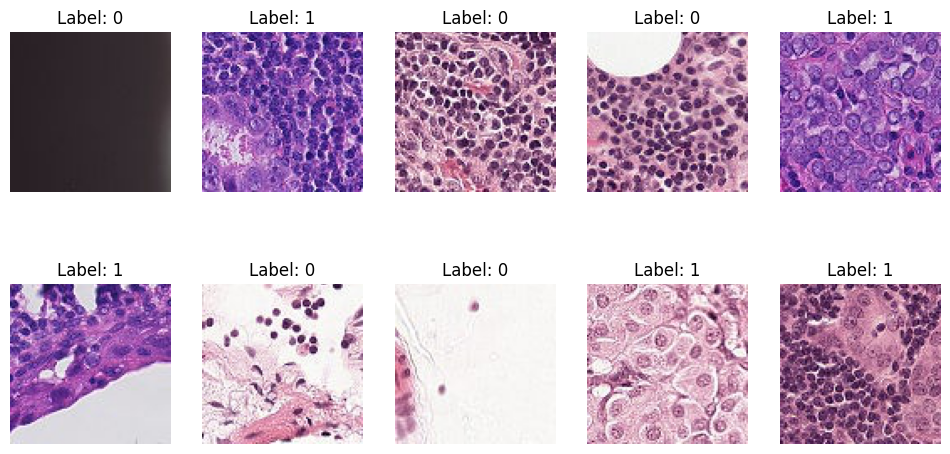

In [26]:
# Plot 10 random images
samples = train_labels.sample(10, random_state=42)

# Plot images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for ax, (img_path, label) in zip(axes.flat, zip(samples["file_path"], samples["label"])):
    ax.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.show()

## **Model Architecture**

Start with Simple CNN Model.

* Conv2D layers: Extract spatial features.
* MaxPooling2D layers: Reduce spatial dimensions.
* Flatten layer: Convert features into a vector.
* Dense layers: Fully connected layers for classification.
* Output layer: Binary classification (sigmoid).


In [38]:
# Define CNN architecture
def build_baseline_cnn(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Regularization to prevent overfitting
        Dense(1, activation='sigmoid')  # Binary classification (Cancer vs. No Cancer)
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [28]:
# Build model
baseline_cnn = build_baseline_cnn()
baseline_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Data Processing

In [29]:
IMG_SIZE = 128
BATCH_SIZE = 32

In [31]:
# ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [33]:
# Convert labels to strings
train_labels["label"] = train_labels["label"].astype(str)

In [34]:
# Train dataset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

Found 176020 validated image filenames belonging to 2 classes.


In [35]:
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 44005 validated image filenames belonging to 2 classes.


In [36]:
EPOCHS = 10

In [37]:
# Train the model
history = baseline_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 174s 31ms/step - accuracy: 0.7870 - loss: 0.4653 - val_accuracy: 0.8535 - val_loss: 0.3460
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 157s 28ms/step - accuracy: 0.8601 - loss: 0.3340 - val_accuracy: 0.8775 - val_loss: 0.2936
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - accuracy: 0.8834 - loss: 0.2847 - val_accuracy: 0.8904 - val_loss: 0.2673
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - accuracy: 0.8941 - loss: 0.2617 - val_accuracy: 0.8979 - val_loss: 0.2613
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 151s 27ms/step - accuracy: 0.9015 - loss: 0.2468 - val_accuracy: 0.8960 - val_loss: 0.2647
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.9089 - loss: 0.2279 - val_accuracy: 0.8856 - val_loss: 0.2751
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 146s 26ms/step - accuracy: 0.9140 - loss: 0.2164 - val_accuracy: 0.8988 - val_loss: 0.2520
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 145s 26ms/step - accuracy: 

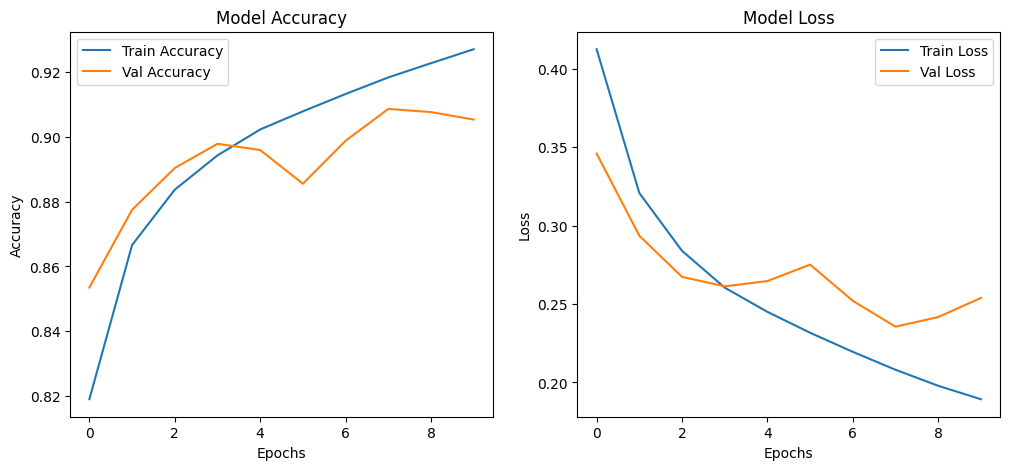

In [39]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy")

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss")

    plt.show()

plot_training_history(history)

Analysis:
* The model is learning well, with both training and validation accuracy reaching over 90%. However, after epoch 4-5, validation accuracy starts fluctuating, while training accuracy keeps increasing, showing signs of overfitting.

* Both training and validation loss decrease, which is good, but validation loss starts going up and down after a few epochs, meaning the model may not generalize well to new data.

* To fix this, we can stop training early when validation loss stops improving, add dropout (0.5) to prevent overfitting, and use data augmentation (rotation, flipping, zooming) to give the model more variety in training examples.

* Lowering the learning rate (e.g., 0.0001) can help the model train more smoothly and avoid sudden jumps in validation loss, making it more stable.

In [40]:
baseline_cnn.save("/content/histopathologic-cancer-cnn.h5")

Evaluate Simple CNN model

In [41]:
IMG_SIZE = (128, 128)

In [42]:
# Create a DataFrame for storing predictions
test_images = os.listdir(test_dir)
submission_df = pd.DataFrame(test_images, columns=["filename"])
submission_df["id"] = submission_df["filename"].str.replace(".tif", "")

In [43]:
# Function to load and preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
# Make predictions
predictions = []
for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    img_array = preprocess_image(img_path)
    pred = baseline_cnn.predict(img_array)[0][0]
    predictions.append(1 if pred > 0.5 else 0)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

In [47]:
# Add predictions to DataFrame
submission_df["label"] = predictions
submission_df = submission_df[["id", "label"]]
print(submission_df.head())

                                         id  label
0  4c02626bcd9e286d2ee57774942bfad36fd4616d      0
1  6b4ea4414b3b3b96d7278c1db3c3ba333f4c7697      0
2  547602df6238856aa4e3737413accd724689b97d      1
3  24445be52febcfdcdfcb2aace502a17c0af24473      0
4  7052b056e4249637bae94b00d0005ba68c55b8b2      0


In [48]:
submission_cnn = "/content/submission_cnn.csv"
submission_df.to_csv(submission_cnn, index=False)

In [50]:
drive_folder = "/content/drive/My Drive/DTSA5511/Week3/"
!cp {submission_cnn} "{drive_folder}"
print(f"CSV file saved to Google Drive: {drive_folder}")

CSV file saved to Google Drive: /content/drive/My Drive/DTSA5511/Week3/


Score: 0.8350

Improved CNN with Regularization & Data Augmentation
* Add more CNN layers to capture patterns
* Batch Normalization to Speed up training & improve stability
* Add Dropout to prevent overfitting
* Data augmentation for generalization
* Learning Rate Scheduler optimize learning over time

In [51]:
# Challenge CNN Model
def build_challenge_cnn(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),  # Normalization layer
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

challenge_cnn = build_challenge_cnn()
challenge_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,617,921 (17.62 MB)

 Trainable params: 4,616,961 (17.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [52]:
# Compile the model
challenge_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [53]:
IMG_SIZE = 128
BATCH_SIZE = 32

In [54]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [55]:
# Train dataset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

Found 176020 validated image filenames belonging to 2 classes.


In [56]:
# Validation dataset
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

Found 44005 validated image filenames belonging to 2 classes.


In [58]:
# Reduce learning rate and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [59]:
EPOCHS = 20

In [ ]:
history_challenge = challenge_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 807s 146ms/step - accuracy: 0.7665 - loss: 0.5284 - val_accuracy: 0.8441 - val_loss: 0.3836 - learning_rate: 1.0000e-04
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 794s 144ms/step - accuracy: 0.8401 - loss: 0.3763 - val_accuracy: 0.8539 - val_loss: 0.3516 - learning_rate: 1.0000e-04
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 792s 144ms/step - accuracy: 0.8717 - loss: 0.3139 - val_accuracy: 0.8981 - val_loss: 0.2812 - learning_rate: 1.0000e-04
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 795s 145ms/step - accuracy: 0.8936 - loss: 0.2719 - val_accuracy: 0.8929 - val_loss: 0.2731 - learning_rate: 1.0000e-04
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 795s 144ms/step - accuracy: 0.9011 - loss: 0.2535 - val_accuracy: 0.9077 - val_loss: 0.2615 - learning_rate: 1.0000e-04
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 793s 144ms/step - accuracy: 0.9085 - loss: 0.2397 - val_accuracy: 0.9012 - val_loss: 0.2618 - learning_rate: 1.0000e-04
Epoch 7/20
5501/5501 ━━━━━━━

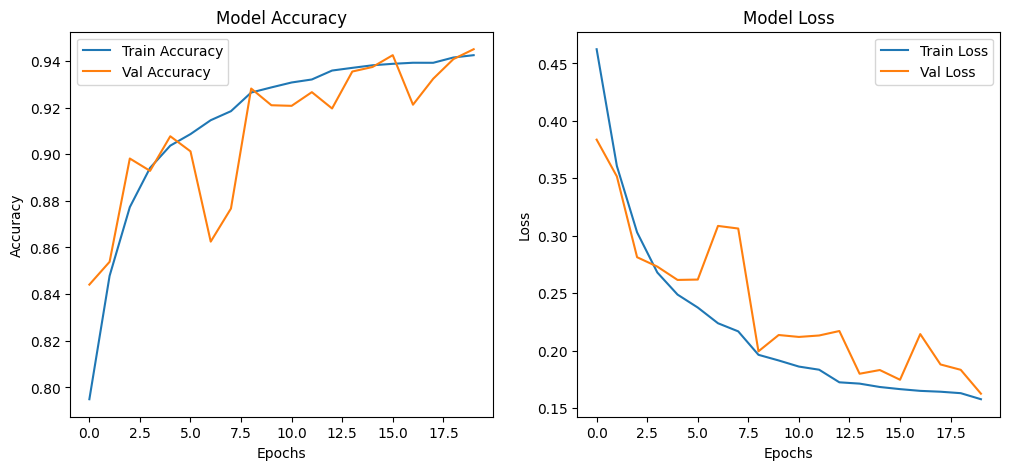

In [62]:
# Function to plot training history
def plot_training_history(history, title="Training Progress"):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy")

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss")

    plt.show()

plot_training_history(history_challenge)

**Analysis**

* Validation accuracy fluctuates throughout training but follows the training accuracy closely, suggesting the model generalizes well.

* Validation loss shows some spikes around epochs 7-8, indicating that the model may still be slightly overfitting, but it recovers and continues improving.

* Lowering the learning rate further can help stabilize training and reduce fluctuations in validation loss.

* Increasing dropout can help smooth out validation accuracy fluctuations.

In [63]:
challenge_cnn.save("/content/challenge_histopathologic_cancer_cnn.h5")
!cp /content/challenge_histopathologic_cancer_cnn.h5 "/content/drive/My Drive/DTSA5511/Week3/"

Evaluate Challenge Model

In [64]:
IMG_SIZE = (128, 128)

In [65]:
# Create a DataFrame for storing predictions
test_images = os.listdir(test_dir)
submission_df = pd.DataFrame(test_images, columns=["filename"])
submission_df["id"] = submission_df["filename"].str.replace(".tif", "")

In [67]:
# Function to load and preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [68]:
# Make predictions
predictions = []
for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    img_array = preprocess_image(img_path)
    pred = baseline_cnn.predict(img_array)[0][0]
    predictions.append(1 if pred > 0.5 else 0)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

In [69]:
# Add predictions to DataFrame
submission_df["label"] = predictions
submission_df = submission_df[["id", "label"]]
print(submission_df.head())

                                         id  label
0  4c02626bcd9e286d2ee57774942bfad36fd4616d      0
1  6b4ea4414b3b3b96d7278c1db3c3ba333f4c7697      0
2  547602df6238856aa4e3737413accd724689b97d      1
3  24445be52febcfdcdfcb2aace502a17c0af24473      0
4  7052b056e4249637bae94b00d0005ba68c55b8b2      0


In [70]:
submission_challenge = "/content/submission_challenge.csv"
submission_df.to_csv(submission_challenge, index=False)

In [71]:
drive_folder = "/content/drive/My Drive/DTSA5511/Week3/"
!cp {submission_challenge} "{drive_folder}"
print(f"CSV file saved to Google Drive: {drive_folder}")

CSV file saved to Google Drive: /content/drive/My Drive/DTSA5511/Week3/


Score: 0.8350

**4. Results and Analysis**

* Both the baseline CNN model and the challenge model achieved the same score 0.8350.
* Despite adding more layers, batch normalization, dropout, and data augmentation, the challenge model did not outperform the baseline in terms of final test set performance.
* The baseline CNN model was already well-optimized, as the challenge model did not outperform it on the test set.
* Further improvements should focus on model selection (ResNet, EfficientNet) and cross-validation techniques rather than increasing CNN depth alone.


**5. Conclusion**

This project successfully implemented CNN models for histopathologic cancer detection, starting with a baseline CNN and an enhanced challenge model with added layers, dropout, and batch normalization. Despite these improvements, both models achieved similar test performance, Accuracy: 0.7932, AUC: 0.8350, indicating that the baseline model was already well-optimized.

The challenge model showed more fluctuations in validation accuracy and loss, but this did not lead to better generalization. Future improvements should focus on pretrained architectures (ResNet, EfficientNet), cross-validation, advanced augmentations, and hyperparameter tuning rather than just increasing model complexity